In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression as LogReg
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display, HTML
import graphviz
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from ipywidgets import interact
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)

In [2]:
# used to ignore warnings

import warnings; warnings.simplefilter('ignore')

In [3]:
test0 = pd.read_csv('https://raw.githubusercontent.com/SeanAntosiak/DS-Unit-2-Regression-Classification/master/data/tanzania/test_features.csv')
train0 = pd.read_csv('https://raw.githubusercontent.com/SeanAntosiak/DS-Unit-2-Regression-Classification/master/data/tanzania/train_features.csv')
trainLabels = pd.read_csv('https://raw.githubusercontent.com/SeanAntosiak/DS-Unit-2-Regression-Classification/master/data/tanzania/train_labels.csv')
sample = pd.read_csv('https://raw.githubusercontent.com/SeanAntosiak/DS-Unit-2-Regression-Classification/master/data/tanzania/sample_submission.csv')

In [4]:
train0.head(1)

id  amount_tsh date_recorded funder  gps_height installer  longitude  \
0  69572      6000.0    2011-03-14  Roman        1390     Roman  34.938093   

   latitude wpt_name  num_private       basin subvillage  region  region_code  \
0 -9.856322     none            0  Lake Nyasa   Mnyusi B  Iringa           11   

   district_code     lga      ward  population public_meeting  \
0              5  Ludewa  Mundindi         109           True   

               recorded_by scheme_management scheme_name permit  \
0  GeoData Consultants Ltd               VWC       Roman  False   

   construction_year extraction_type extraction_type_group  \
0               1999         gravity               gravity   

  extraction_type_class management management_group       payment  \
0               gravity        vwc       user-group  pay annually   

  payment_type water_quality quality_group quantity quantity_group  source  \
0     annually          soft          good   enough         enough  spring   

  source_type source_class     waterpoint_type waterpoint_type_group  
0      spring  groundwater  communal standpipe    communal standpipe

In [5]:
# checks if quantity column is a duplicate
# since there are no rows where the two are not equal
# I will drop one of the rows later

train0[train0['quantity']!=train0['quantity_group']][['quantity','quantity_group']].head()

Empty DataFrame
Columns: [quantity, quantity_group]
Index: []

In [6]:
# checks if payment column is a duplicate
# it is not but they convey the same information 
# I will drop one of the rows later

train0[train0['payment']!=train0['payment_type']][['payment','payment_type']].head()

payment payment_type
0            pay annually     annually
2          pay per bucket   per bucket
5          pay per bucket   per bucket
11  pay when scheme fails   on failure
13            pay monthly      monthly

In [7]:
# checks if quantity colunm is a duplicate
# they look to convey the same information 
# will look further to see if I should drop

train0[train0['scheme_management']!=train0['management']][['scheme_management','management']].head()

scheme_management management
0               VWC        vwc
1             Other        wug
2               VWC        vwc
3               VWC        vwc
4               NaN      other

In [8]:
# checking occurances of each value

train0['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [9]:
# close to the same values as the other column,
# I will just keep one of these columns

train0['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [10]:
# looking at how these three columns relate
# it looks as if source and source_type represent the same thing
# but source_class is a more broad classification from 2 catagories
# I will drop the source column later
 
train0[train0['source_type']!=train0['source']][['source','source_type','source_class']].head(10)


source source_type source_class
3   machine dbh    borehole  groundwater
6   machine dbh    borehole  groundwater
8   machine dbh    borehole  groundwater
10  machine dbh    borehole  groundwater
15  machine dbh    borehole  groundwater
16        river  river/lake      surface
17        river  river/lake      surface
22        river  river/lake      surface
23        river  river/lake      surface
26  machine dbh    borehole  groundwater

In [11]:
# checking to see if waterpoint type is a duplicate col
# need to check further

train0[train0['waterpoint_type_group']!=train0['waterpoint_type']][['waterpoint_type_group','waterpoint_type']].head(10)

waterpoint_type_group              waterpoint_type
2     communal standpipe  communal standpipe multiple
3     communal standpipe  communal standpipe multiple
5     communal standpipe  communal standpipe multiple
53    communal standpipe  communal standpipe multiple
55    communal standpipe  communal standpipe multiple
62    communal standpipe  communal standpipe multiple
75    communal standpipe  communal standpipe multiple
89    communal standpipe  communal standpipe multiple
95    communal standpipe  communal standpipe multiple
96    communal standpipe  communal standpipe multiple

In [12]:
# checking values for waterpoint group

train0['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [13]:
# this column apears to have communal standpipe split into two seperate columns
# I will keep this column and drop the other

train0['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [14]:
# looking at how these three columns relate
# its hard to tell but type_class seems to be the most broad 
# and extraction_type the most spesific
# I will look a little more before deciding to drop anything
 
train0[train0['extraction_type']!=train0['extraction_type_group']][['extraction_type','extraction_type_group','extraction_type_class']].head()

extraction_type extraction_type_group extraction_type_class
31                ksb           submersible           submersible
45           windmill          wind-powered          wind-powered
66  other - rope pump             rope pump             rope pump
88                ksb           submersible           submersible
92                ksb           submersible           submersible

In [15]:
# checking how many rows have different values for two of the columns
# it is a pretty big number, but even so most of the values are still 
# matched up pretty consistently (example: ksb is always matched with submersible)
# i will compare this shape to the size of the total Dataframe 

train0[train0['extraction_type']!=train0['extraction_type_group']][['extraction_type','extraction_type_group','extraction_type_class']].shape

(2469, 3)

In [16]:
# the last columns are only a small portion of the total
# I will drop the later two columns for now
# I may add them back if needed later

train0.shape

(59400, 40)

In [17]:
# checking if row is duplicate
# not enough information yet to decide on droping

train0[['water_quality', 'quality_group']].head()

water_quality quality_group
0          soft          good
1          soft          good
2          soft          good
3          soft          good
4          soft          good

In [18]:
# checking value counts of water quality column when the columns dont have the same values

train0[train0['water_quality']!=train0['quality_group']][['water_quality','quality_group']]['water_quality'].value_counts()

soft                  50818
coloured                490
salty abandoned         339
fluoride abandoned       17
Name: water_quality, dtype: int64

In [19]:
# looks the same as the last column but changes soft to good.
# I will drop the water_quality column

train0[train0['water_quality']!=train0['quality_group']][['water_quality','quality_group']]['quality_group'].value_counts()

good        50818
colored       490
salty         339
fluoride       17
Name: quality_group, dtype: int64

In [20]:
# only one value, will remove column

train0['recorded_by'].value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [21]:
# check what percentage of pumps work

trainLabels['status_group'].value_counts(normalize=True)

# since ~54.3% of pumps work, a baseline model of always guessing yes would have an accuracy of 54.3%

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [60]:
# checking if a population of 0 is reasonable or likely just missing information

train0[train0['population']==0].head()

# since most of the time a row with a population of 0 also has a amount tsh,
# and a gps height of 0 I will assume this is missing infromation and 
# will replace the 0 values with nan later

id  amount_tsh date_recorded       funder  gps_height  installer  \
4  19728         0.0    2011-07-13  Action In A           0    Artisan   
6  19816         0.0    2012-10-01         Dwsp           0       DWSP   
7  54551         0.0    2012-10-09        Rwssp           0        DWE   
8  53934         0.0    2012-11-03     Wateraid           0  Water Aid   
9  46144         0.0    2011-08-03  Isingiro Ho           0    Artisan   

   longitude  latitude           wpt_name  num_private            basin  \
4  31.130847 -1.825359            Shuleni            0    Lake Victoria   
6  33.362410 -3.766365         Kwa Ngomho            0         Internal   
7  32.620617 -4.226198       Tushirikiane            0  Lake Tanganyika   
8  32.711100 -5.146712  Kwa Ramadhan Musa            0  Lake Tanganyika   
9  30.626991 -1.257051            Kwapeto            0    Lake Victoria   

        subvillage     region  region_code  district_code              lga  \
4       Kyanyamisa     Kagera           18              1          Karagwe   
6    Ishinabulandi  Shinyanga           17              3  Shinyanga Rural   
7  Nyawishi Center  Shinyanga           17              3           Kahama   
8       Imalauduki     Tabora           14              6     Tabora Urban   
9         Mkonomre     Kagera           18              1          Karagwe   

         ward  population public_meeting              recorded_by  \
4  Nyakasimbi           0           True  GeoData Consultants Ltd   
6      Samuye           0           True  GeoData Consultants Ltd   
7      Chambo           0           True  GeoData Consultants Ltd   
8    Itetemia           0           True  GeoData Consultants Ltd   
9      Kaisho           0           True  GeoData Consultants Ltd   

  scheme_management scheme_name permit  construction_year extraction_type  \
4               NaN         NaN   True                  0         gravity   
6               VWC         NaN   True                  0          swn 80   
7               NaN         NaN   True                  0     nira/tanira   
8               VWC         NaN   True                  0   india mark ii   
9               NaN         NaN   True                  0     nira/tanira   

  extraction_type_group extraction_type_class management management_group  \
4               gravity               gravity      other            other   
6                swn 80              handpump        vwc       user-group   
7           nira/tanira              handpump        wug       user-group   
8         india mark ii              handpump        vwc       user-group   
9           nira/tanira              handpump        vwc       user-group   

     payment payment_type water_quality quality_group  quantity  \
4  never pay    never pay          soft          good  seasonal   
6  never pay    never pay          soft          good    enough   
7    unknown      unknown         milky         milky    enough   
8  never pay    never pay         salty         salty  seasonal   
9  never pay    never pay          soft          good    enough   

  quantity_group                source           source_type source_class  \
4       seasonal  rainwater harvesting  rainwater harvesting      surface   
6         enough           machine dbh              borehole  groundwater   
7         enough          shallow well          shallow well  groundwater   
8       seasonal           machine dbh              borehole  groundwater   
9         enough          shallow well          shallow well  groundwater   

      waterpoint_type waterpoint_type_group  
4  communal standpipe    communal standpipe  
6           hand pump             hand pump  
7           hand pump             hand pump  
8           hand pump             hand pump  
9           hand pump             hand pump

In [65]:
# checking if region corelates with region_code

train0[['region', 'region_code']].T

# it looks as if it does, but region_code is a little more spesific
# I will drop the region_code column

0     1        2       3       4      5          6      \
region       Iringa  Mara  Manyara  Mtwara  Kagera  Tanga  Shinyanga   
region_code      11    20       21      90      18      4         17   

                 7       8       9      10      11         12           13     \
region       Shinyanga  Tabora  Kagera  Pwani  Ruvuma  Shinyanga  Kilimanjaro   
region_code         17      14      18     60      10         17            3   

                 14     15      16      17      18      19      20     \
region       Shinyanga  Rukwa  Iringa  Iringa  Mwanza  Iringa  Iringa   
region_code         17     15      11      11      19      11      11   

                 21      22           23      24           25     26     \
region       Shinyanga  Iringa  Kilimanjaro  Kigoma  Kilimanjaro  Lindi   
region_code         17      11            3      16            3     80   

              27           28           29      30     31           32     \
region       Kagera  Kilimanjaro  Kilimanjaro  Dodoma  Pwani  Kilimanjaro   
region_code      18            3            3       1      6            3   

              33     34      35     36      37      38      39     \
region       Iringa  Pwani  Arusha  Mbeya  Dodoma  Iringa  Kigoma   
region_code      11     60       2     12       1      11      16   

                   40      41      42       43      44         45      46     \
region       Kilimanjaro  Iringa  Iringa  Singida  Arusha  Shinyanga  Mtwara   
region_code            3      11      11       13       2         17      90   

             47      48      49           50     51     52      53      54     \
region       Mbeya  Iringa  Iringa  Kilimanjaro  Rukwa  Mbeya  Mwanza  Kagera   
region_code     12      11      11            3     15     12      19      18   

                   55           56      57       58      59     60     61     \
region       Kilimanjaro  Kilimanjaro  Arusha  Manyara  Kagera  Tanga  Tanga   
region_code            3            3       2       21      18      4      4   

              62      63       64       65      66      67      68      69     \
region       Kigoma  Arusha  Singida  Singida  Iringa  Kagera  Iringa  Kigoma   
region_code      16       2       13       13      11      18      11      16   

                70     71     72    73      74      75      76      77     \
region       Morogoro  Mbeya  Mbeya  Mara  Kigoma  Kagera  Iringa  Arusha   
region_code         5     12     12    20      16      18      11       2   

             78         79      80        81      82         83    84     \
region       Tanga  Shinyanga  Iringa  Morogoro  Arusha  Shinyanga  Mara   
region_code      4         17      11         5       2         17    20   

              85      86      87     88      89      90     91     92     \
region       Mwanza  Iringa  Kagera  Pwani  Dodoma  Kigoma  Lindi  Pwani   
region_code      19      11      18      6       1      16     80      6   

               93      94      95      96      97      98         99     \
region       Manyara  Kagera  Kigoma  Kigoma  Mwanza  Ruvuma  Shinyanga   
region_code       21      18      16      16      19      10         17   

             100      101     102     103          104          105    \
region       Tanga  Singida  Kigoma  Ruvuma  Kilimanjaro  Kilimanjaro   
region_code      4       13      16      10            3            3   

                 106     107     108    109     110     111     112    113    \
region       Shinyanga  Kagera  Iringa  Mbeya  Arusha  Arusha  Kagera  Mbeya   
region_code         17      18      11     12       2       2      18     12   

              114     115       116   117   118      119     120     121    \
region       Dodoma  Kagera  Morogoro  Mara  Mara  Manyara  Iringa  Kagera   
region_code       1      18         5    20    20       21      11      18   

              122     123    124     125      126     127        128    \
region     

In [183]:
# checks number of unique values for each feature compared to the unique values for that feature

dfUnique0 = pd.DataFrame()
dfUnique0['dtypes'] = train0.dtypes
dfUnique0['unique_values'] = train0.nunique()
dfUnique0

# id is not a continuous variable, and its variance is too high so I will remove the column
# other values have to high of varience and I will adress that later

dtypes  unique_values
id                       int64          59400
amount_tsh             float64             98
date_recorded           object            356
funder                  object           1897
gps_height               int64           2428
installer               object           2145
longitude              float64          57516
latitude               float64          57517
wpt_name                object          37400
num_private              int64             65
basin                   object              9
subvillage              object          19287
region                  object             21
region_code              int64             27
district_code            int64             20
lga                     object            125
ward                    object           2092
population               int64           1049
public_meeting          object              2
recorded_by             object              1
scheme_management       object             12
scheme_name             object           2696
permit                  object              2
construction_year        int64             55
extraction_type         object             18
extraction_type_group   object             13
extraction_type_class   object              7
management              object             12
management_group        object              5
payment                 object              7
payment_type            object              7
water_quality           object              8
quality_group           object              6
quantity                object              5
quantity_group          object              5
source                  object             10
source_type             object              7
source_class            object              3
waterpoint_type         object              7
waterpoint_type_group   object              6

In [23]:
# creates train and test split

Xtrain0, Xval0, ytrain0, yval0 = tts(train0, trainLabels['status_group'], train_size=0.85, test_size=0.15, random_state=8)

In [229]:
# creates a function to wrangle an input dataframe and returns wrangled dataframe

def wrangle1(DF):
    
    # creates a copy of the input dataframe
    df = DF.copy()
    
    # removes colums refererenced earlier
    df = df.drop(columns=['id', 'recorded_by', 'quantity_group', 'region_code', 'payment', 'management',
                          'source', 'waterpoint_type_group', 'extraction_type_group', 
                          'extraction_type_class', 'water_quality'])
    
    # converts date_recorded to a year
    df['date_recorded'] = pd.to_datetime(df['date_recorded'], infer_datetime_format=True).dt.year
    
    # defines the columns which apear to have missing values input as 0
    zeroCols = ['amount_tsh', 'longitude', 'latitude', 'gps_height', 'construction_year']
    
    # replaces missing 0 values with nan
    for col in zeroCols:
        df[col] = df[col].replace(0, np.nan);
    
    
    # replaces tiny latitude values with 0 to be replaced with nan in the next step 
    df['latitude']=df['latitude'].replace(-2e-8,0)
    
    # creates a list of columns to be grouped
    groupCols = ['funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name']
    
    # renames all values not in the top 10 most common values for a given row to be "other"
    for col in groupCols:
        top10 = df[col].value_counts()[:10].index
        df.loc[~df[col].isin(top10), col] = 'other';
    
        
    return(df);

In [230]:
# applies wrangle function to each dataframe

Xtrain1 = wrangle1(Xtrain0)
Xval1 = wrangle1(Xval0)
Xtest1 = wrangle1(test0)

In [231]:
# checks number to see if features got converted correctly

dfUnique1 = pd.DataFrame()
dfUnique1['dtypes'] = Xtrain1.dtypes
dfUnique1['unique_values'] = Xtrain1.nunique()
dfUnique1

dtypes  unique_values
amount_tsh         float64             96
date_recorded        int64              5
funder              object             11
gps_height         float64           2413
installer           object             11
longitude          float64          48899
latitude           float64          48900
wpt_name            object             11
num_private          int64             60
basin               object              9
subvillage          object             11
region              object             21
district_code        int64             20
lga                 object             11
ward                object             11
population           int64            997
public_meeting      object              2
scheme_management   object             12
scheme_name         object             11
permit              object              2
construction_year  float64             54
extraction_type     object             18
management_group    object              5
payment_type        object              7
quality_group       object              6
quantity            object              5
source_type         object              7
source_class        object              3
waterpoint_type     object              7

In [232]:
# creates a pipeline to encode, impute, and scale certain features
# then creates a decision tree

pipe1 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    MinMaxScaler(),
    LogReg(solver='lbfgs', multi_class='auto', max_iter=1000)
)

In [233]:
# fits pipeline to training data

pipe1.fit(Xtrain1, ytrain0)

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'management_group', 'payment_type', 'quality_group', 'quantity', 'source_type', 'source_c...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [234]:
# checks accuracy of pipe1 on validation data

pipe1.score(Xval1, yval0)

0.7414141414141414

In [237]:
#gets coefficients for each feature
coefs1 = pipe1.named_steps['logisticregression'].coef_[0]

#gets column names corelated with each feature
colNames1 = pipe1.named_steps['onehotencoder'].fit_transform(Xtrain1).columns

#creates a dataframe with coefs and their column names
coeDF1 = pd.Series(coefs1, colNames1)

coeDF1

funder_other                                   0.161017
funder_Kkkt                                   -0.056978
funder_Unicef                                  0.237285
funder_Hesawa                                 -0.294014
funder_Rwssp                                   0.262060
funder_District Council                       -0.232838
funder_Government Of Tanzania                 -0.006985
funder_Danida                                  0.205215
funder_World Bank                             -0.126065
funder_World Vision                           -0.057501
funder_Tasaf                                  -0.081498
funder_-1                                      0.000000
installer_DWE                                 -0.089269
installer_other                                0.024701
installer_KKKT                                -0.404524
installer_0                                    0.221959
installer_Hesawa                               0.337967
installer_Government                          -0

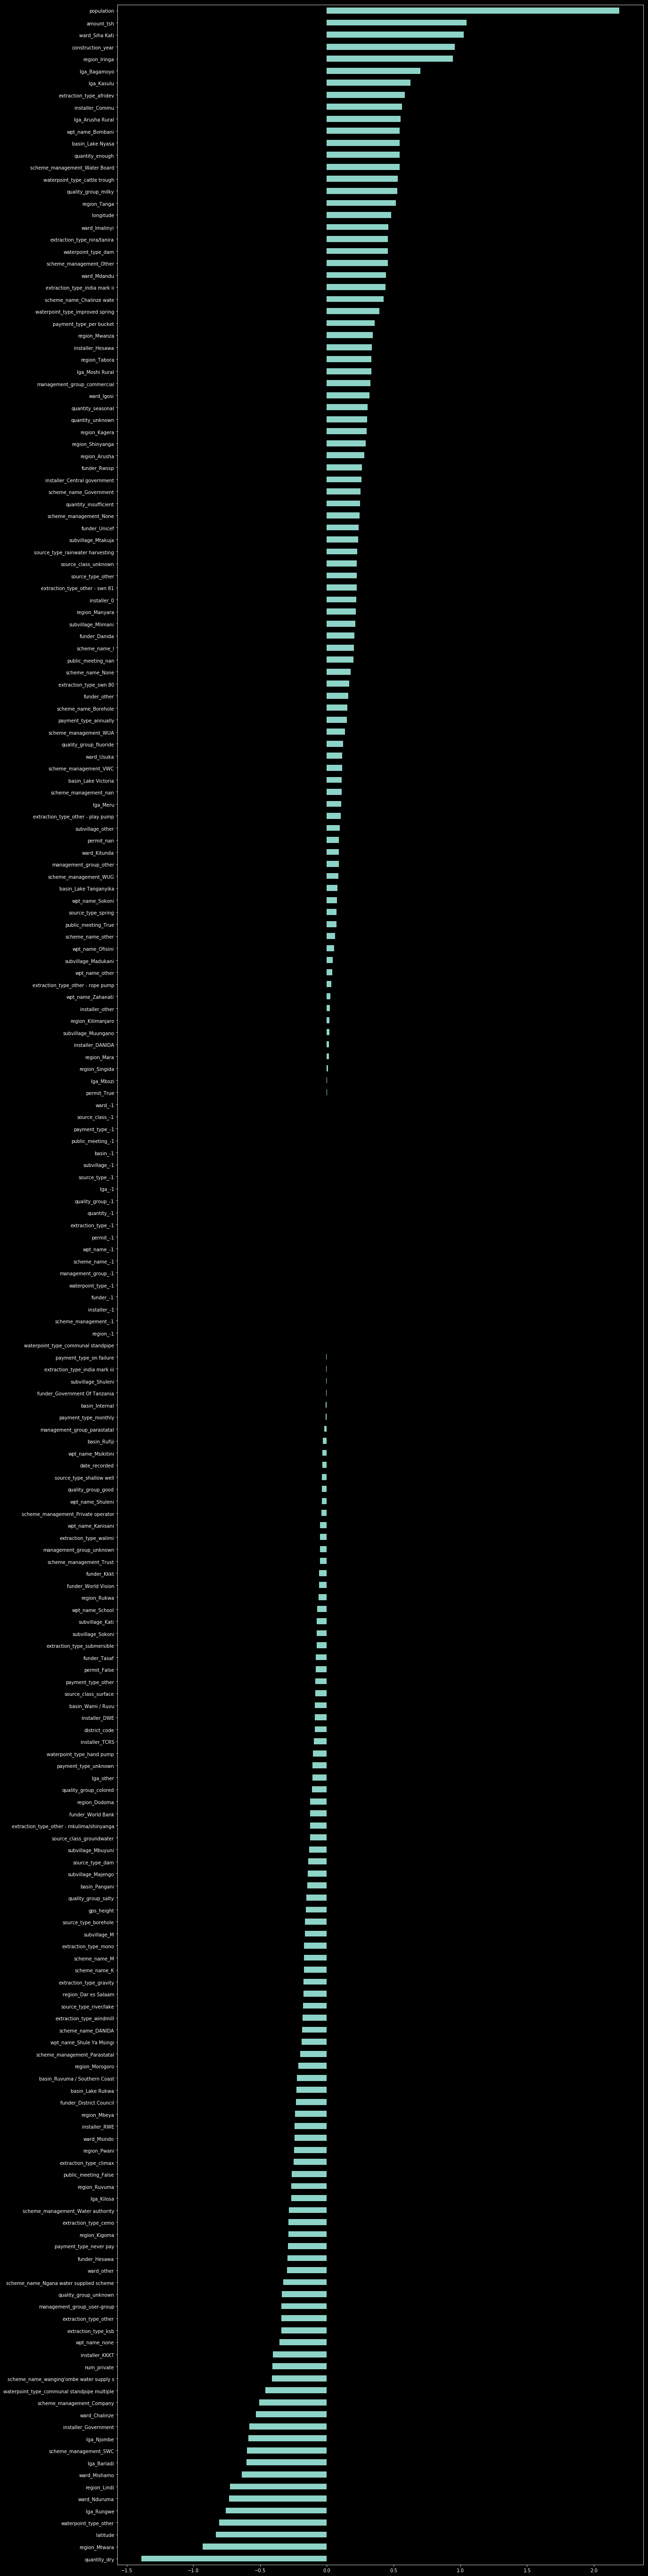

In [238]:
# creates a plot to show importance of each feature

plt.style.use('dark_background')
fig = plt.figure(figsize=(20,100))
ax = plt.axes()

coeDF1.sort_values().plot.barh();

In [239]:
# creates a second pipeline for a decision tree after using one hot encoding

pipe2 = make_pipeline(
    make_pipeline(
        ce.OneHotEncoder(use_cat_names=True),
        SimpleImputer(),
        MinMaxScaler(), 
    ),
DecisionTreeClassifier(max_depth=10, min_samples_leaf=25,random_state=8)
)

In [240]:
# fits second pipeline

pipe2.fit(Xtrain1, ytrain0)

Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'management_group', 'payment_type', 'quali...         min_weight_fraction_leaf=0.0, presort=False, random_state=8,
            splitter='best'))])

In [241]:
# checks decision tree accuracy

pipe2.score(Xval1, yval0)

0.7502805836139169

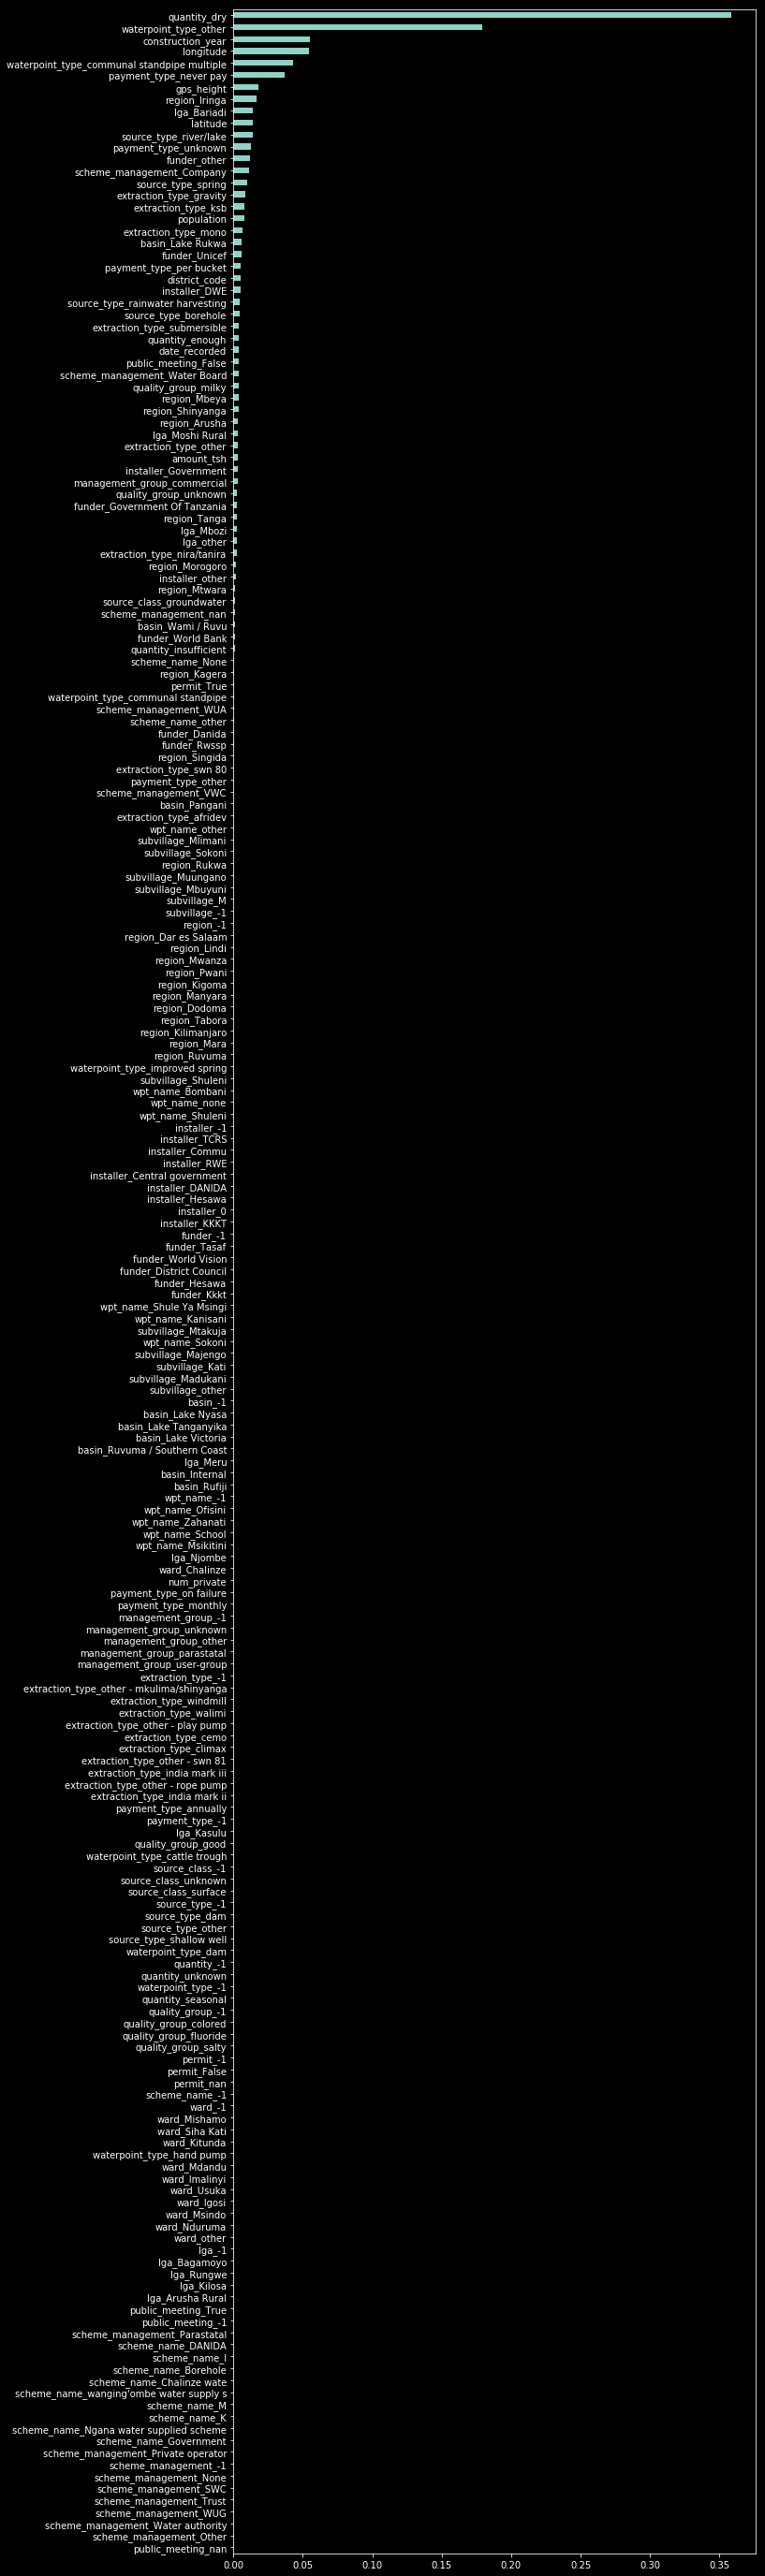

In [256]:
# shows importance values for decision tree

mod2 = pipe2.named_steps['decisiontreeclassifier']
encoder2 = pipe2.named_steps['pipeline'].named_steps['onehotencoder']
encodedCols = encoder2.fit_transform(Xtrain1).columns
importance2 = pd.Series(mod2.feature_importances_, encodedCols)
plt.figure(figsize=(10,50))
importance2.sort_values().plot.barh();

In [261]:
# creates predictions from test data using pipe2

pred2 = pipe2.predict(Xtest1)

In [263]:
# creating a submission dataframe

submission2 = sample.copy()
submission2['status_group'] = pred2

In [265]:
# creates submission file for challenge

submission2.to_csv('submission2.csv', index=False)